In [48]:
import pandas as pd 
import numpy as np 
import pathlib as path
import matplotlib.pyplot as plt
import random
from PIL import Image
from random import sample
from cmath import nan
import json

from scipy import stats


In [49]:
#define the relevant path to the current batch you wish to parse
gap_name='pilot_24_hours' #dont change this as this parsing sciprt only handles the same day batches.  

project_name='multicategory'
experiment_name='experiment 1'
batch_name='batch 3'
qualification_method='loose' #or 'loose'  - defines different disqualification criterions (add this suffix to the saved file)

PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' / gap_name / batch_name
PATH_TO_BATCH_DATA = PATH_TO_BATCH / 'data'

if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\User\Desktop\visual_memory\visual_memory_representation_final\projects\multicategory\experiment 1\collected data\pilot_24_hours\batch 3


In [50]:

qualification_name_for_testin='UPDATE-completed encoding multicategory memory test'  #note that the -space- after the title is improtant as for some reason this is how the qualification name is defined
qualification_name_for_entire_experiment='UPDATE-completed multicategory memory test'

In [51]:
def set_criterions(type='strict'):
    #the function sets the criterions and returns them as a pd.series
    criterions_df=pd.Series(dtype=float)

    #update the non changing ciretrions: 
    criterions_df['demo_arrow_correctness']=1
    criterions_df['encoding_arrow_accuracy']=0.6
    criterions_df['longest_allowed_consequtive_strike']=15
    criterions_df['fast_threshold']=0.3
    criterions_df['rating_varience_demo'] = 0

    if type=='strict':
        criterions_df['demo_accuracy_treshold']=0.5 
        
        criterions_df['fast_allowed_count']=3 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 
        criterions_df['binom_single_layer']=0.7
        criterions_df['binom_averages']=0.65
        criterions_df['rating_varience_test'] = 1
        
    elif type=='loose': #here we change things to be easier to pass
        criterions_df['demo_accuracy_treshold']=0
        criterions_df['fast_threshold']=0.3
        criterions_df['fast_allowed_count']=5 
        criterions_df['slow_threshold']=10
        criterions_df['slow_allowed_count']=2
        # rsulting in significan binom test with a loose alpha of 0.1 instead of 0.05 
        criterions_df['binom_single_layer']=0.666
        criterions_df['binom_averages']=0.6166
        criterions_df['rating_varience_test'] = 0.5
    else: 
        raise Exception('requested method is not defined')
    
    return criterions_df


In [52]:

criterions_df=set_criterions(qualification_method)
criterions_df

demo_arrow_correctness                 1.00
encoding_arrow_accuracy                0.60
longest_allowed_consequtive_strike    15.00
fast_threshold                         0.30
rating_varience_demo                   0.00
demo_accuracy_treshold                 0.00
fast_allowed_count                     5.00
slow_threshold                        10.00
slow_allowed_count                     2.00
binom_single_layer                     0.55
binom_averages                         0.55
rating_varience_test                   0.50
dtype: float64

In [53]:
#this section loads the shelf dict in the state it is after finishing the testing session for this batch. 
shelf_dict_after_test_name=PATH_TO_BATCH / 'shelf after test session closed.txt' #define the name of the relevant shelf for this stage
with open(shelf_dict_after_test_name) as f:
    data = f.read()
shelf_dict = json.loads(data)
shelf_dict


{'A19PB6VUP0RAC3': [9, 1682949997166, 1683029612907, 1683030155680],
 'A1ABRVTR49OA73': [21, 1682950049077, 1683032370299, 1683041181284],
 'A1AMGHYG5PT0L2': [39, 1682950918763, 1683033162919],
 'A1BQLX0A4W8A8': [83,
  1682964250527,
  1683030823745,
  1683030930529,
  1683031003758,
  1683031140415,
  1683031305050,
  1683039824808,
  1683039997462],
 'A1DIYFGQT1QDV2': [31, 1682950355274, 1683046479268],
 'A1PRUVH5Q0T9FS': [4, 1682949745590, 1683025740833],
 'A1Q3GKUJF8EWHG': [93, 1682981721758, 1683056413973, 1683061178454],
 'A1YALKEEJHHWSO': [62, 1682954227335, 1683032969147, 1683033390032],
 'A2AN972XU7OY8W': [81, 1682962776227, 1683049184845],
 'A2F48NO7AD9VKK': [23, 1682950399994, 1683036067950],
 'A2FREFX5AGACUZ': [46,
  1682980285878,
  1683054419004,
  1683054438957,
  1683062649288,
  1683065582318],
 'A2J9NFY45NKR2N': [18, 1682949882285, 1683033522450],
 'A2NC28XJKAFJV': [78, 1682962022271, 1683046189022],
 'A39KMTFHRJJASK': [82, 1682963122891, 1683049864717],
 'A3EWBTHYFI4

In [54]:
#this section reads all the relevant files: 
if (PATH_TO_BATCH / 'Batch_encoding_batch_results.csv').exists():
    encoding_df=pd.read_csv(PATH_TO_BATCH / 'Batch_encoding_batch_results.csv')
else: 
    print(f'no "Batch_encoding_batch_results.csv" was found in data')

if (PATH_TO_BATCH / 'Batch_testing_batch_results.csv').exists():
    testing_df=pd.read_csv(PATH_TO_BATCH / 'Batch_testing_batch_results.csv')
else: 
    print(f'no "Batch_testing_batch_results.csv" was found in data (probably because only the encoding session finished)')
if (PATH_TO_BATCH / 'Batch_workers_after_test.csv').exists():
    workers_df=pd.read_csv(PATH_TO_BATCH / 'Batch_workers_after_test.csv')
else:
    print('No AMAZON worker list was found: please make sure to upload one and name it correctly')



In [55]:
def find_largest_consequtive_repetition(responses_array):
#add a stop value so the loop will use the logic also if the end of the responses is all repeating: 
    responses_array=np.append(responses_array,[99])
    longest_rep_dict=dict()
    last_input=responses_array[0]
    consequtive_rep_counter=0
    for response in responses_array[1:]: 
        if response==last_input: #if consequtive rep: 
            consequtive_rep_counter=consequtive_rep_counter+1 #add to counter
        else: #once a new entry is in the vector - store the counter rep information 
            if last_input in longest_rep_dict.keys(): #if it was allready stored in our dictionary
                if longest_rep_dict[last_input]<consequtive_rep_counter: #replace the counter only if it is higher than what stored in dict
                    longest_rep_dict[last_input]=consequtive_rep_counter
            else: #this entry is not yet in the dictionary: add it 
                longest_rep_dict[last_input]=consequtive_rep_counter
            
            consequtive_rep_counter=0
            last_input=response
    return max(longest_rep_dict.values())

In [56]:
def process_worker_results(PATH_TO_BATCH_DATA,subject_name,parse_type='encoding'):
    cur_sub=pd.read_csv(PATH_TO_BATCH_DATA / subject_name)
    sub_demographics=cur_sub[['workID','Age','Gender']].iloc[0]

    #extract demo related information: 

    #if participant did not click on the arrow during the demo a 'demo_encoding_response.rt' colmumn wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    demo_columns=['demo_encoding_loop.thisTrialN','DemoImage','DemoCorrect','demo_encoding_response.rt','demo_encoding_response.keys']
    demo_test_columns=['demo_test_response.keys','demo_test_response.corr','demo_test_response.rt','demo_test_loop.thisTrialN','DemoImage1','DemoImage2','DemoCorrectTest','demo_bar_2.response']

    #encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target','pair','layer','correct','test_encoding_response.rt','key_resp_end.keys']
    encoding_related_columns=['test_encoding_response.keys','test_encoding_response.corr','trials.thisTrialN','target','correct','test_encoding_response.rt','key_resp_end.keys']
    test_related_columns=['layer','correct','test_test_response.keys','test_test_response.corr','test_test_response.rt','trials_2.thisRepN','trials_2.thisTrialN','trials_2.thisN','trials_2.thisIndex','trials_2.ran','image1','image2','bar_2.response']


    if not('demo_encoding_response.rt' in cur_sub.columns):
        cur_sub['demo_encoding_response.rt']=np.nan  

    if (parse_type=='encoding'):
        sub_demo_information=cur_sub[demo_columns]
        empty_inds=sub_demo_information.loc[sub_demo_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_information=sub_demo_information.drop(index=empty_inds)


        #extract the demo test columns: 
        sub_demo_test_information=cur_sub[demo_test_columns]
        empty_inds=sub_demo_test_information.loc[sub_demo_test_information.isnull().apply(lambda x: all(x), axis=1)].index
        #drop irrelevant columns: 
        sub_demo_test_information=sub_demo_test_information.drop(index=empty_inds)

        demo_df=pd.concat([sub_demo_information.reset_index(),sub_demo_test_information.reset_index()],axis=1)

    #extract real experiment related information: 

    #if participant did not click on the arrow during the encoding a 'test_encoding_response.rt' column wont exists: 
    #thus we will create one and fill it with nans (so everything will be consistent with other participants)
    if not('test_encoding_response.rt' in cur_sub.columns):
        cur_sub['test_encoding_response.rt']=np.nan
        

    if (parse_type=='encoding') | (parse_type=='all'):
        sub_encoding_information=cur_sub[encoding_related_columns]
        #encoding section ends with a key press of the space key: so seperate this phase by finding this space key row
        end_of_section_ind=np.where(sub_encoding_information['key_resp_end.keys']=='space')[0][0]
        sub_encoding_information=sub_encoding_information.iloc[0:end_of_section_ind]
        #remove all the rows that precede the real encoding phase: 
        empty_inds=sub_encoding_information.loc[sub_encoding_information.isnull().apply(lambda x: all(x), axis=1)].index
        sub_encoding_information=sub_encoding_information.drop(index=empty_inds).reset_index()

    if (parse_type=='test') | (parse_type=='all'):
    #extract real experiment TEST related information: 
        sub_test_information=cur_sub[test_related_columns].dropna()


    subject_dictionary=dict()
    subject_dictionary['demographics']=sub_demographics
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['demo_df']=demo_df
    if (parse_type=='encoding') | (parse_type=='all'):
        subject_dictionary['encoding_df']=sub_encoding_information
    if (parse_type=='test') | (parse_type=='all'):
        subject_dictionary['test_df']=sub_test_information

    return subject_dictionary



In [57]:

#get all results with Encoding information - extract the arrow attention check accuracy and RT (RT is currently not usd as a criterion)

#this section extract the list of participants from the downloaded results files (and not via the workers or session list csvs) 
# - it will create the qualification_df (a table with information on the worker ids and encoding behavior of all participants that we have files for)
all_filenames=[file for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name]
#print(f'current csv files:\n{all_filenames}')

qualification_for_test_df=pd.DataFrame(columns=['workerID','arrow_acc','mean_arrow_RT'])
for subject_csv in all_filenames:
    print(subject_csv.name)
    subject_dict=process_worker_results(PATH_TO_BATCH_DATA,path.Path(subject_csv))
    cur_sub_encoding=subject_dict['encoding_df']

    sname=subject_csv.name.split('_')[1] #change according to actuall format. 

    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all
        arrow_acc=0
        RT=nan
    else: 
        RT=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_acc=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
    sub_df=pd.DataFrame({'workerID':sname,'arrow_acc':arrow_acc,'mean_arrow_RT':RT},index=[sname])
    qualification_for_test_df=pd.concat([qualification_for_test_df,sub_df],axis=0)

#the following part update the qualification_df with information on wether the participant id exists in the amazon workers list: 

#change participants qualifications if they exists in the workers list based on thier encoding arrow accuracy
qualification_for_test_df['in_encoding_workers_list']=nan

for curr_worker_ID in qualification_for_test_df.index:
    if curr_worker_ID in encoding_df['WorkerId'].values:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(1)
    else:
        qualification_for_test_df.loc[curr_worker_ID,'in_encoding_workers_list']=int(0)


ENCODING_A105M4JOZSR7E6_2023-05-03_11h50.28.988.csv
ENCODING_A151XA53WYXVD7_2023-05-03_14h57.15.606.csv
ENCODING_A16BUREYCTMSOC_2023-05-03_10h59.02.023.csv
ENCODING_A18GEAFI5MMW02_2023-05-03_10h55.24.802.csv
ENCODING_A1969Q0R4Y0E3J_2023-05-03_11h52.35.098.csv
ENCODING_A1B8OVQXUY3WQ6_2023-05-03_12h30.59.160.csv
ENCODING_A1DDWUJ5R357SW_05-03-2023_14h21.20.755.csv
ENCODING_A1FN28N3CFL552_05-03-2023_15h06.07.666.csv
ENCODING_A1GQWLAZQZP5VR_2023-05-03_11h06.35.244.csv
ENCODING_A1HLQV5HX3WUK4_2023-05-03_14h02.41.791.csv
ENCODING_A1IMLTXT2RBEFO_2023-05-04_24h37.23.238.csv
ENCODING_A1SL10V8CDNI9H_2023-05-03_23h38.05.999.csv
ENCODING_A1T8VILAKHKGR1_2023-05-03_18h05.52.893.csv
ENCODING_A1VJ4ZOXP9PUCP_2023-05-03_10h55.30.181.csv
ENCODING_A1Y3JL53XAO7QV_2023-05-03_12h45.59.454.csv
ENCODING_A1Y8FC2FCI0RZ5_05-04-2023_03h08.12.174.csv
ENCODING_A20ZFQ93DF0WA_2023-05-03_14h58.17.456.csv
ENCODING_A237PUN7791D62_2023-05-03_11h00.58.101.csv
ENCODING_A2541C8MY0BYV3_2023-05-03_07h58.20.748.csv
ENCODING_A25P

In [58]:
all_subjects_demo_df=pd.DataFrame()
all_subjects_encoding_df=pd.DataFrame()
all_subjects_test_df=pd.DataFrame()
all_subjects_biographics_df=pd.DataFrame()
all_filenames=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'TEST' in file.name]

for subject_test_filename in all_filenames:
    subject_name=subject_test_filename.split('_')[1]
    subject_encoding_filename=[file.name for file in PATH_TO_BATCH_DATA.iterdir() if 'csv' in file.name and 'ENCODING' in file.name and subject_name in file.name][0]
    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_encoding_filename,parse_type='encoding')
    curr_demo_df=curr_subject_dictionary['demo_df']
    curr_demo_df['subject']=subject_name
    curr_encoding_df=curr_subject_dictionary['encoding_df']
    curr_encoding_df['subject']=subject_name
    curr_demographics_df=curr_subject_dictionary['demographics']
    curr_demographics_df['subject']=subject_name

    curr_subject_dictionary=process_worker_results(PATH_TO_BATCH_DATA,subject_test_filename,parse_type='test')
    curr_test_df=curr_subject_dictionary['test_df']
    curr_test_df['subject']=subject_name



    all_subjects_demo_df=pd.concat([all_subjects_demo_df,curr_demo_df],axis=0,ignore_index=True)
    all_subjects_encoding_df=pd.concat([all_subjects_encoding_df,curr_encoding_df],axis=0,ignore_index=True)
    all_subjects_test_df=pd.concat([all_subjects_test_df,curr_test_df],axis=0,ignore_index=True)
    all_subjects_biographics_df=pd.concat([all_subjects_biographics_df,pd.DataFrame(curr_demographics_df).T],axis=0,ignore_index=True)


all_subjects_demo_df.to_csv(PATH_TO_BATCH / 'all_subjects_demo_df.csv')
all_subjects_encoding_df.to_csv(PATH_TO_BATCH / 'all_subjects_encoding_df.csv')
all_subjects_test_df.to_csv(PATH_TO_BATCH / 'all_subjects_test_df.csv')
all_subjects_biographics_df.to_csv(PATH_TO_BATCH / 'all_subjects_biographics_df.csv')

In [59]:
all_subjects_biographics_df

,workID,Age,Gender,subject
0,A105M4JOZSR7E6,27,female,A105M4JOZSR7E6
1,A151XA53WYXVD7,43,Male,A151XA53WYXVD7
2,A1969Q0R4Y0E3J,25,Female,A1969Q0R4Y0E3J
3,A1VJ4ZOXP9PUCP,33,female,A1VJ4ZOXP9PUCP
4,A20ZFQ93DF0WA,25,MALE,A20ZFQ93DF0WA
5,A237PUN7791D62,68,Male,A237PUN7791D62
6,A2541C8MY0BYV3,35,Male,A2541C8MY0BYV3
7,A25PFSORDO3SWQ,35,male,A25PFSORDO3SWQ
8,A2CZ5PS567SA10,45,male,A2CZ5PS567SA10
9,A2P9XYDUCQBXWD,25,Female,A2P9XYDUCQBXWD


In [60]:
from unicodedata import category

# if there are any empty values - fill with mean of subjects age 
mean_value = all_subjects_biographics_df['Age'].mean()
all_subjects_biographics_df['Age'].fillna(value=mean_value, inplace=True)
all_subjects_biographics_df['Age'] = all_subjects_biographics_df['Age'].astype(np.int64)

all_subjects_biographics_df['Age']=all_subjects_biographics_df['Age'].astype(int)
all_subjects_biographics_df['Gender'].replace({'woman':'female','FEMLAE':'female','Male':'male','MALE':'male','FEMALE':'female','Female':'female','ale':'male'},inplace=True)
if len(np.unique(all_subjects_biographics_df['Gender'].values))<=2:
    print('transformed the gender column to be consistent having two possible values:',np.unique(all_subjects_biographics_df['Gender'].values))
else: 
    print('gender is still inconsistent with more than 2 unique values:',np.unique(all_subjects_biographics_df['Gender'].values))
all_subjects_biographics_df['Gender']=all_subjects_biographics_df['Gender'].astype("category")

mean_age,min_age,max_age=all_subjects_biographics_df['Age'].mean(),all_subjects_biographics_df['Age'].min(),all_subjects_biographics_df['Age'].max()
female_prop=all_subjects_biographics_df.loc[all_subjects_biographics_df['Gender']=='female','Gender'].count()/all_subjects_biographics_df['Gender'].count()

print(f'Mean age: {mean_age:.2f}, range: [{min_age} - {max_age}], {female_prop:.2f}% female')


transformed the gender column to be consistent having two possible values: ['female' 'male']
Mean age: 35.68, range: [25 - 68], 0.40% female


# this part plots the seperate dataframes: 
### demo phase (encoding and test in the same dataframe)
### encoding experiment phase
### test experiment phase

In [61]:
all_subjects_demo_df.head(5)

,index,demo_encoding_loop.thisTrialN,DemoImage,DemoCorrect,demo_encoding_response.rt,demo_encoding_response.keys,index,demo_test_response.keys,demo_test_response.corr,demo_test_response.rt,demo_test_loop.thisTrialN,DemoImage1,DemoImage2,DemoCorrectTest,demo_bar_2.response,subject
0,4,0.0,flower1.jpg,NaN,NaN,NaN,12.0,left,1.0,3.0075,0.0,flower1.jpg,flower1_pair.jpg,left,6.0,A105M4JOZSR7E6
1,5,1.0,flower2.jpg,NaN,NaN,NaN,13.0,left,0.0,2.2469,1.0,flower2_pair.jpg,flower2.jpg,right,7.0,A105M4JOZSR7E6
2,6,2.0,left.jpg,left,0.911,left,14.0,right,0.0,7.7231,2.0,flower3.jpg,flower3_pair.jpg,left,7.0,A105M4JOZSR7E6
3,7,3.0,flower3.jpg,NaN,NaN,NaN,15.0,left,1.0,20.7350,3.0,flower4.jpg,flower4_pair.jpg,left,5.0,A105M4JOZSR7E6
4,8,4.0,flower4.jpg,NaN,NaN,NaN,16.0,right,1.0,3.3213,4.0,flower5_pair.jpg,flower5.jpg,right,4.0,A105M4JOZSR7E6


In [62]:
all_subjects_encoding_df.head(5)

,index,test_encoding_response.keys,test_encoding_response.corr,trials.thisTrialN,target,correct,test_encoding_response.rt,key_resp_end.keys,subject
0,20,NaN,1.0,0.0,badlands_70.jpg,NaN,NaN,NaN,A105M4JOZSR7E6
1,21,NaN,1.0,1.0,highway_394.jpg,NaN,NaN,NaN,A105M4JOZSR7E6
2,22,NaN,1.0,2.0,bridge_191.jpg,NaN,NaN,NaN,A105M4JOZSR7E6
3,23,NaN,1.0,3.0,bridge_250.jpg,NaN,NaN,NaN,A105M4JOZSR7E6
4,24,NaN,1.0,4.0,bridge_256.jpg,NaN,NaN,NaN,A105M4JOZSR7E6


In [63]:
all_subjects_test_df.head(5)

,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,image1,image2,bar_2.response,subject
0,1.0,left,left,1.0,2.9503,0.0,0.0,0.0,0.0,1.0,mountain_101.jpg,mountain_221.jpg,6.0,A105M4JOZSR7E6
1,1.0,left,right,0.0,1.9766,0.0,1.0,1.0,1.0,1.0,mountain_57.jpg,mountain_138.jpg,6.0,A105M4JOZSR7E6
2,1.0,left,left,1.0,1.7092,0.0,2.0,2.0,2.0,1.0,badlands_221.jpg,badlands_207.jpg,5.0,A105M4JOZSR7E6
3,1.0,left,left,1.0,1.6800,0.0,3.0,3.0,3.0,1.0,golf_course_193.jpg,golf_course_123.jpg,6.0,A105M4JOZSR7E6
4,0.0,left,right,0.0,2.2979,0.0,4.0,4.0,4.0,1.0,badlands_24.jpg,badlands_3.jpg,5.0,A105M4JOZSR7E6


In [64]:
#this section extract information from the demo phase: it creates a df (all_subjects_summary_demo_info) containingsingle row per participants with metrics from the demo phase (average accuracy, RTs and so on (this can be used to screen participatns for further analysis)):
all_subjects_summary_demo_info=pd.DataFrame(index=list(all_subjects_demo_df['subject'].unique()))

for cur_subject in all_subjects_demo_df['subject'].unique():
    cur_sub_demo_encoding=all_subjects_demo_df.loc[all_subjects_demo_df['subject']==cur_subject]
    
    #get only attention check related info: 
    curr_subjects_summary_demo_info=cur_sub_demo_encoding[['demo_encoding_response.keys','DemoCorrect','demo_encoding_response.rt']].copy().dropna()
    if len(curr_subjects_summary_demo_info)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0 
       all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=np.nan
    else: 
        all_subjects_summary_demo_info.loc[cur_subject,'arrow_rt']=curr_subjects_summary_demo_info['demo_encoding_response.rt'].values
        if all(curr_subjects_summary_demo_info['DemoCorrect']==curr_subjects_summary_demo_info['demo_encoding_response.keys']):
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=1
        else:
            all_subjects_summary_demo_info.loc[cur_subject,'arrow_correct']=0


    #get the correctness of the demo testing phase: 
    cur_sub_demo_test_performence=cur_sub_demo_encoding[['DemoCorrectTest','demo_test_response.keys','demo_test_response.rt']].copy().dropna()
    test_match_df=pd.DataFrame(columns=['arrow_correct'],data=cur_sub_demo_test_performence['DemoCorrectTest']==cur_sub_demo_test_performence['demo_test_response.keys'])
    test_match_df['demo_test_response.rt']=cur_sub_demo_test_performence['demo_test_response.rt']
    accuracy=test_match_df['arrow_correct'].mean()
    mean_rt=test_match_df['demo_test_response.rt'].mean()
    correct_and_incorrect_rts=test_match_df.groupby('arrow_correct').aggregate({'demo_test_response.rt':'mean'})

    # rating 
    rating_var = cur_sub_demo_encoding['demo_bar_2.response'].std()
    

    #update the summary info row: 
    all_subjects_summary_demo_info.loc[cur_subject,'demo_accuracy']=accuracy
    all_subjects_summary_demo_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_demo_info.loc[cur_subject,'rating_varience']=rating_var
    all_subjects_summary_demo_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan



    if False in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts.loc[False].values[0]
    if True in correct_and_incorrect_rts.index:
        all_subjects_summary_demo_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts.loc[True].values[0]


#add a prefix to column names: 
all_subjects_summary_demo_info.columns=['demo_'+col for col in all_subjects_summary_demo_info.columns]
all_subjects_summary_demo_info

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean
A105M4JOZSR7E6,0.9110,1.0,0.500000,6.535333,1.211060,4.049400,9.021267
A151XA53WYXVD7,1.1640,1.0,0.666667,4.281333,0.516398,3.440500,4.701750
A1969Q0R4Y0E3J,0.6609,1.0,0.666667,3.215017,1.940790,3.956100,2.844475
A1VJ4ZOXP9PUCP,0.6974,1.0,1.000000,1.991400,0.752773,NaN,1.991400
A20ZFQ93DF0WA,0.9519,1.0,0.833333,2.439050,0.752773,2.239900,2.478880
A237PUN7791D62,0.5593,1.0,0.500000,5.564150,2.280351,5.355933,5.772367
A2541C8MY0BYV3,1.0310,1.0,0.500000,7.465833,1.169045,10.431667,4.500000
A25PFSORDO3SWQ,0.7190,1.0,1.000000,4.016000,1.471960,NaN,4.016000
A2CZ5PS567SA10,1.1577,1.0,0.333333,3.413433,0.632456,3.667225,2.905850
A2P9XYDUCQBXWD,1.9790,1.0,0.333333,7.840183,1.471960,8.719425,6.081700


In [65]:
curr_subjects_summary_demo_info
cur_subject

'AW07POT8ABE05'

In [66]:
#this part extract summary information from the experiment encoding phase: attention check accuracy and timings: 
all_subjects_summary_encoding_info=pd.DataFrame(index=list(all_subjects_encoding_df['subject'].unique()))

for cur_subject in all_subjects_encoding_df['subject'].unique():
    cur_sub_encoding=all_subjects_encoding_df.loc[all_subjects_encoding_df['subject']==cur_subject]
    
    #get only attention check related info: 
    cur_sub_encoding=cur_sub_encoding[['test_encoding_response.keys','correct','test_encoding_response.rt']].copy().dropna(how = 'all')
    if len(cur_sub_encoding)==0: #empty - the participant didnt respond on the arrow at all: 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=0 
       all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=np.nan
    else: 
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_mean_rt']=cur_sub_encoding['test_encoding_response.rt'].mean()
        arrow_accuracy=(cur_sub_encoding['correct']==cur_sub_encoding['test_encoding_response.keys']).mean()
        all_subjects_summary_encoding_info.loc[cur_subject,'arrow_accuracy']=arrow_accuracy



#add a prefix to column names: 
all_subjects_summary_encoding_info.columns=['encoding_'+col for col in all_subjects_summary_encoding_info.columns]        
all_subjects_summary_encoding_info

,encoding_arrow_mean_rt,encoding_arrow_accuracy
A105M4JOZSR7E6,1.231933,0.6
A151XA53WYXVD7,1.084400,1.0
A1969Q0R4Y0E3J,0.507540,1.0
A1VJ4ZOXP9PUCP,0.876480,1.0
A20ZFQ93DF0WA,1.147200,1.0
A237PUN7791D62,0.594060,1.0
A2541C8MY0BYV3,0.518400,1.0
A25PFSORDO3SWQ,0.592400,1.0
A2CZ5PS567SA10,1.196060,1.0
A2P9XYDUCQBXWD,1.664060,1.0


In [67]:
#this part extract summary information from the experiment testing phase: attention check accuracy and timings: 
all_subjects_summary_testing_info=pd.DataFrame(index=list(all_subjects_test_df['subject'].unique()))


#this code calculates response time averages (RT) exlcusing the trials that are TOO long: 
trial_too_long_exclusion_criteria=10


for cur_subject in all_subjects_test_df['subject'].unique():
    cur_sub_testing=all_subjects_test_df.loc[all_subjects_test_df['subject']==cur_subject]

    #get the correctness of the testing phase: 
    cur_sub_testing_performence=cur_sub_testing[['correct','test_test_response.keys','test_test_response.rt','layer','test_test_response.corr']].copy().dropna()


    test_match_df=pd.DataFrame(columns=['correct'],data=cur_sub_testing_performence['correct']==cur_sub_testing_performence['test_test_response.keys'])
    test_match_df['test_test_response.rt']=cur_sub_testing_performence['test_test_response.rt']
    accuracy=test_match_df['correct'].mean()

    # if there is one rt that is very long, lets not include it in the mean calculation 
    
    mean_rt=(test_match_df.loc[test_match_df['test_test_response.rt']<=trial_too_long_exclusion_criteria,'test_test_response.rt']).mean()
    correct_and_incorrect_rts_overall=test_match_df.groupby('correct').aggregate({'test_test_response.rt':'mean'})
    
    rating_var = cur_sub_testing['bar_2.response'].std()
    rating_mean = cur_sub_testing['bar_2.response'].mean()
    rating_mean_layer_1 = cur_sub_testing.groupby('layer')['bar_2.response'].mean()[0]
    rating_mean_layer_3 = cur_sub_testing.groupby('layer')['bar_2.response'].mean()[1]
    #update the summary info row: 
    all_subjects_summary_testing_info.loc[cur_subject,'Test_overall_accuracy']=accuracy
    all_subjects_summary_testing_info.loc[cur_subject,'RT_overall_mean']=mean_rt
    all_subjects_summary_testing_info.loc[cur_subject,'rating_varience']=rating_var
    all_subjects_summary_testing_info.loc[cur_subject,'rating_mean']=rating_mean
    all_subjects_summary_testing_info.loc[cur_subject,'layer_1_rating']=rating_mean_layer_1
    all_subjects_summary_testing_info.loc[cur_subject,'layer_3_rating']=rating_mean_layer_3
    all_subjects_summary_testing_info.loc[cur_subject,['RT_incorrect_mean','RT_correct_mean']]=np.nan

    if False in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_incorrect_mean']=correct_and_incorrect_rts_overall.loc[False].values[0]
    if True in correct_and_incorrect_rts_overall.index:
        all_subjects_summary_testing_info.loc[cur_subject,'RT_correct_mean']=correct_and_incorrect_rts_overall.loc[True].values[0]



    #extract layer wise information (accuracy and rt):
    cur_sub_testing_performence_copy=cur_sub_testing_performence.copy()
    cur_sub_testing_performence_copy.loc[cur_sub_testing_performence_copy['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
    correct_and_incorrect_rts=cur_sub_testing_performence_copy.groupby('layer').aggregate({'test_test_response.rt':'mean','test_test_response.corr':'mean'})
    all_subjects_summary_testing_info.loc[cur_subject,['layer_1_rt','layer_1_accuracy','layer_3_rt','layer_3_accuracy']]=correct_and_incorrect_rts.values.flatten()


    #check the longest structured strike (to find bots or very unattentive participants):
    responses=cur_sub_testing_performence['test_test_response.keys'].replace({'left':1,'right':2}).values
    max_iter=find_largest_consequtive_repetition(responses)

    all_subjects_summary_testing_info.loc[cur_subject,'longest_response_strike']=max_iter

#add a prefix to column names: 
all_subjects_summary_testing_info.columns=['testing_'+col for col in all_subjects_summary_testing_info.columns]        
all_subjects_summary_testing_info

,testing_Test_overall_accuracy,testing_RT_overall_mean,testing_rating_varience,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A105M4JOZSR7E6,0.516667,2.061502,1.106095,4.883333,4.666667,5.100000,2.433817,4.533658,2.086719,0.533333,2.038807,0.500000,4.0
A151XA53WYXVD7,0.700000,2.792379,1.956013,5.733333,5.066667,6.400000,2.811944,3.320476,2.826267,0.766667,2.756071,0.633333,7.0
A1969Q0R4Y0E3J,0.716667,2.518234,2.314289,4.000000,3.366667,4.633333,3.260712,2.432247,2.392666,0.733333,2.639617,0.700000,7.0
A1VJ4ZOXP9PUCP,0.683333,2.022720,1.748284,5.166667,4.400000,5.933333,2.201379,1.939927,1.841797,0.766667,2.203643,0.600000,4.0
A20ZFQ93DF0WA,0.616667,1.580148,0.738566,6.616667,6.833333,6.400000,1.538117,1.606276,1.723217,0.666667,1.437080,0.566667,6.0
A237PUN7791D62,0.800000,4.135263,1.709396,5.600000,5.400000,5.800000,4.682217,3.998525,4.096250,0.766667,4.174277,0.833333,5.0
A2541C8MY0BYV3,0.566667,2.253617,1.551380,4.000000,3.966667,4.033333,2.155692,2.328500,2.204800,0.600000,2.302433,0.533333,5.0
A25PFSORDO3SWQ,0.850000,4.588073,1.610260,3.483333,3.200000,3.766667,6.142667,4.994039,4.552185,0.800000,4.622679,0.900000,4.0
A2CZ5PS567SA10,0.683333,3.244330,0.799717,5.933333,5.966667,5.900000,6.046611,3.353383,3.348021,0.800000,3.136936,0.566667,9.0
A2P9XYDUCQBXWD,0.583333,1.309753,2.530939,7.366667,6.733333,8.000000,1.100220,2.330909,1.510841,0.633333,1.115367,0.533333,58.0


In [68]:
cur_sub_testing_performence.loc[cur_sub_testing_performence['test_test_response.rt']>trial_too_long_exclusion_criteria,'test_test_response.rt']=nan
cur_sub_testing_performence

,correct,test_test_response.keys,test_test_response.rt,layer,test_test_response.corr
1440,right,left,4.1396,0.0,0.0
1441,right,right,3.3192,0.0,1.0
1442,right,right,2.5876,0.0,1.0
1443,left,left,1.8027,1.0,1.0
1444,left,left,1.5387,0.0,1.0
1445,right,right,2.4430,1.0,1.0
1446,left,left,2.2590,0.0,1.0
1447,right,right,1.7660,0.0,1.0
1448,left,left,1.6419,1.0,1.0
1449,right,left,3.3729,1.0,0.0


In [69]:
def find_outlier_responses(sub_test_dataframe,fast_threshold=0.1,fast_allowed_count=2,slow_threshold=10,slow_allowed_count=2):
    isfast_outlier=(sub_test_dataframe['test_test_response.rt']<fast_threshold).sum()>fast_allowed_count
    isslow_outlier=(sub_test_dataframe['test_test_response.rt']>slow_threshold).sum()>slow_allowed_count
    return isfast_outlier,isslow_outlier

In [70]:
#combine all oneliners into a single matrix - 1 line per participant with all information we want:
data_df_for_analysis=pd.concat([all_subjects_summary_demo_info,all_subjects_summary_encoding_info,all_subjects_summary_testing_info],axis=1)



#as each participant saw 20 distractors per layer, we need atleast 0.75 (15/20) accuracy in one of the layers or above 0.616 (37/60) in the overall: 

#how many participants would fail the demo (did not correctly answered the arrow or had less than 60% performence)
demo_criterions_accuracy=data_df_for_analysis['demo_demo_accuracy']>=criterions_df['demo_accuracy_treshold']
demo_criterions_attention_check=data_df_for_analysis['demo_arrow_correct']>=criterions_df['demo_arrow_correctness']
#find which participants performed pooly on the attention checks of the experiment encoding phase: 
encoding_ciriterions=data_df_for_analysis['encoding_arrow_accuracy']>criterions_df['encoding_arrow_accuracy']
#remove participants that are too slow: 
test_criterions_strike=data_df_for_analysis['testing_longest_response_strike']<criterions_df['longest_allowed_consequtive_strike']

too_fast_criterions=[]
too_slow_criterions=[]
for subject in data_df_for_analysis.index:
    sub_test_dataframe=all_subjects_test_df[all_subjects_test_df['subject']==subject]
    toofast_criterion,tooslow_criterion=find_outlier_responses(sub_test_dataframe,fast_threshold=criterions_df['fast_threshold'],fast_allowed_count=criterions_df['fast_allowed_count'],slow_threshold=criterions_df['slow_threshold'],slow_allowed_count=criterions_df['slow_allowed_count'])
    too_slow_criterions.append(not tooslow_criterion)
    too_fast_criterions.append(not toofast_criterion)


# remove patients with a rating varience that is very low - didnt rate acuratly. 
demo_criterion_rating_var = data_df_for_analysis['demo_rating_varience']>criterions_df['rating_varience_demo']
test_criterion_rating_var = data_df_for_analysis['testing_rating_varience']>criterions_df['rating_varience_test']

print(f'summary for criterions:')
print(f'demo accuracy higher than {criterions_df.demo_accuracy_treshold} - qualified: {demo_criterions_accuracy.sum()}')
print(f'demo attention check correctness equals {criterions_df.demo_arrow_correctness} - qualified: {demo_criterions_attention_check.sum()}')
print(f'experiment encoding attention check accuracy {criterions_df.encoding_arrow_accuracy} - qualified: {encoding_ciriterions.sum()}')
print(f'experiment longest consequtive strike of maximum of  {criterions_df.longest_allowed_consequtive_strike} responses - qualified: {test_criterions_strike.sum()}')
print(f'test too fast (thresold: {criterions_df.fast_threshold}, allowed count: {criterions_df.fast_allowed_count} qualified: {sum(too_fast_criterions)}')
print(f'test too slow (thresold: {criterions_df.slow_threshold}, allowed count: {criterions_df.slow_allowed_count} qualified: {sum(too_slow_criterions)}')
print(f'demo rating varience higher than {criterions_df.rating_varience_demo} - qualified: {len(demo_criterion_rating_var)}')

#accuracy criterion on the test: 
test_accuracy_critertions=(data_df_for_analysis['testing_Test_overall_accuracy']>=criterions_df['binom_averages']) | (data_df_for_analysis[['testing_layer_1_accuracy' ,'testing_layer_3_accuracy']]>=criterions_df['binom_single_layer']).T.any()
#remove participants that were discarded based on behavior up to the test and now qualify or disqualify based on test accuracy (do they have atleast 1 significant (binomial test) accuracy in one layer, or above threshold in overall accuracy )
only_qualified=demo_criterions_accuracy & demo_criterions_attention_check & encoding_ciriterions & test_criterions_strike & too_fast_criterions & too_slow_criterions & test_accuracy_critertions & demo_criterion_rating_var
print(f'above chance accuracy in test, qualified: {sum(test_accuracy_critertions)}')
print(f'OVERALL: number of qualified participants (adhere to all criterions): {sum(only_qualified)}')


summary for criterions:
demo accuracy higher than 0.0 - qualified: 25
demo attention check correctness equals 1.0 - qualified: 25
experiment encoding attention check accuracy 0.6 - qualified: 23
experiment longest consequtive strike of maximum of  15.0 responses - qualified: 21
test too fast (thresold: 0.3, allowed count: 5.0 qualified: 24
test too slow (thresold: 10.0, allowed count: 2.0 qualified: 20
demo rating varience higher than 0.0 - qualified: 25
above chance accuracy in test, qualified: 20
OVERALL: number of qualified participants (adhere to all criterions): 13


In [71]:
#update the batch_workers_df  with columns representing disqualification reasons: 
tooslow_df=pd.DataFrame(data=too_slow_criterions,index=data_df_for_analysis.index,columns=['not_too_slow'])
toofast_df=pd.DataFrame(data=too_fast_criterions,index=data_df_for_analysis.index,columns=['not_too_Fast'])
test_accuracy_critertions=pd.DataFrame(data=test_accuracy_critertions,index=data_df_for_analysis.index, columns=['sufficient_test_acc'])
disqualification_df=pd.concat([demo_criterions_accuracy,demo_criterions_attention_check,encoding_ciriterions,test_criterions_strike,tooslow_df,toofast_df,test_accuracy_critertions],axis=1)
disqualification_df


,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc
A105M4JOZSR7E6,True,True,False,True,False,True,False
A151XA53WYXVD7,True,True,True,True,True,True,True
A1969Q0R4Y0E3J,True,True,True,True,True,True,True
A1VJ4ZOXP9PUCP,True,True,True,True,True,True,True
A20ZFQ93DF0WA,True,True,True,True,True,True,True
A237PUN7791D62,True,True,True,True,True,True,True
A2541C8MY0BYV3,True,True,True,True,True,True,True
A25PFSORDO3SWQ,True,True,True,True,False,True,True
A2CZ5PS567SA10,True,True,True,True,False,True,True
A2P9XYDUCQBXWD,True,True,True,False,True,True,True


In [72]:
#merge workers_df with disqualification and save: 
index_list=[ind.split('_')[0] for ind in disqualification_df.index]
disqualification_df['WorkerId']=index_list

batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'inner')
batch_workers_df_extended = workers_df.merge(disqualification_df, left_on='Worker ID', right_on='WorkerId', how = 'outer')

#add qualification column: (currently any participant will get this qualification (even if he just openneded the experiment and quit, because we dont want him back)
batch_workers_df_extended[qualification_name_for_entire_experiment]=1



In [73]:
#extract data that passes all criterions: 
final_participants_df=data_df_for_analysis[only_qualified]
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A151XA53WYXVD7,1.1640,1.0,0.666667,4.281333,0.516398,3.440500,4.701750,1.08440,1.0,0.700000,...,5.733333,5.066667,6.400000,2.811944,3.320476,2.826267,0.766667,2.756071,0.633333,7.0
A1969Q0R4Y0E3J,0.6609,1.0,0.666667,3.215017,1.940790,3.956100,2.844475,0.50754,1.0,0.716667,...,4.000000,3.366667,4.633333,3.260712,2.432247,2.392666,0.733333,2.639617,0.700000,7.0
A1VJ4ZOXP9PUCP,0.6974,1.0,1.000000,1.991400,0.752773,NaN,1.991400,0.87648,1.0,0.683333,...,5.166667,4.400000,5.933333,2.201379,1.939927,1.841797,0.766667,2.203643,0.600000,4.0
A20ZFQ93DF0WA,0.9519,1.0,0.833333,2.439050,0.752773,2.239900,2.478880,1.14720,1.0,0.616667,...,6.616667,6.833333,6.400000,1.538117,1.606276,1.723217,0.666667,1.437080,0.566667,6.0
A237PUN7791D62,0.5593,1.0,0.500000,5.564150,2.280351,5.355933,5.772367,0.59406,1.0,0.800000,...,5.600000,5.400000,5.800000,4.682217,3.998525,4.096250,0.766667,4.174277,0.833333,5.0
A2541C8MY0BYV3,1.0310,1.0,0.500000,7.465833,1.169045,10.431667,4.500000,0.51840,1.0,0.566667,...,4.000000,3.966667,4.033333,2.155692,2.328500,2.204800,0.600000,2.302433,0.533333,5.0
A2TQ9IHDHCSQC8,1.6880,1.0,0.666667,2.873000,0.894427,3.674000,2.472500,1.13460,1.0,0.733333,...,7.450000,7.466667,7.433333,5.086875,2.656614,2.571833,0.766667,2.935241,0.700000,3.0
A2UWEAIX8UZXAQ,1.0604,1.0,0.666667,1.910883,0.752773,2.269250,1.731700,0.55488,1.0,0.883333,...,6.683333,6.800000,6.566667,4.281586,3.894564,3.711467,0.933333,4.167967,0.833333,7.0
A32X8WXMIV4KE8,0.9670,1.0,0.500000,5.386000,0.632456,5.518000,5.254000,1.07880,1.0,0.700000,...,6.200000,6.533333,5.866667,4.209833,3.947929,3.860100,0.733333,4.192900,0.666667,6.0
A3ATB5GC4BQIH0,1.1010,1.0,0.833333,4.678833,1.471960,5.753000,4.464000,0.86280,1.0,0.666667,...,6.983333,6.833333,7.133333,3.824850,3.491150,3.370862,0.633333,3.370900,0.700000,5.0


In [74]:
total_data = pd.concat([data_df_for_analysis,disqualification_df], axis = 1)
total_data.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_layer_3_accuracy,testing_longest_response_strike,demo_demo_accuracy,demo_arrow_correct,encoding_arrow_accuracy,testing_longest_response_strike,not_too_slow,not_too_Fast,sufficient_test_acc,WorkerId
A105M4JOZSR7E6,0.9110,1.0,0.500000,6.535333,1.211060,4.0494,9.021267,1.231933,0.6,0.516667,...,0.500000,4.0,True,True,False,True,False,True,False,A105M4JOZSR7E6
A151XA53WYXVD7,1.1640,1.0,0.666667,4.281333,0.516398,3.4405,4.701750,1.084400,1.0,0.700000,...,0.633333,7.0,True,True,True,True,True,True,True,A151XA53WYXVD7
A1969Q0R4Y0E3J,0.6609,1.0,0.666667,3.215017,1.940790,3.9561,2.844475,0.507540,1.0,0.716667,...,0.700000,7.0,True,True,True,True,True,True,True,A1969Q0R4Y0E3J
A1VJ4ZOXP9PUCP,0.6974,1.0,1.000000,1.991400,0.752773,NaN,1.991400,0.876480,1.0,0.683333,...,0.600000,4.0,True,True,True,True,True,True,True,A1VJ4ZOXP9PUCP
A20ZFQ93DF0WA,0.9519,1.0,0.833333,2.439050,0.752773,2.2399,2.478880,1.147200,1.0,0.616667,...,0.566667,6.0,True,True,True,True,True,True,True,A20ZFQ93DF0WA


In [75]:
final_participants_df.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_valid_subjects_only_' + qualification_method + '.csv'))
total_data.to_csv(PATH_TO_BATCH / ('one_line_per_participant_all_info_all_subject_' + qualification_method + '.csv'))
criterions_df.to_csv(PATH_TO_BATCH /('criterions_info_' + qualification_method + '.csv'),index=True)

In [76]:
final_participants_df

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_rating_mean,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike
A151XA53WYXVD7,1.1640,1.0,0.666667,4.281333,0.516398,3.440500,4.701750,1.08440,1.0,0.700000,...,5.733333,5.066667,6.400000,2.811944,3.320476,2.826267,0.766667,2.756071,0.633333,7.0
A1969Q0R4Y0E3J,0.6609,1.0,0.666667,3.215017,1.940790,3.956100,2.844475,0.50754,1.0,0.716667,...,4.000000,3.366667,4.633333,3.260712,2.432247,2.392666,0.733333,2.639617,0.700000,7.0
A1VJ4ZOXP9PUCP,0.6974,1.0,1.000000,1.991400,0.752773,NaN,1.991400,0.87648,1.0,0.683333,...,5.166667,4.400000,5.933333,2.201379,1.939927,1.841797,0.766667,2.203643,0.600000,4.0
A20ZFQ93DF0WA,0.9519,1.0,0.833333,2.439050,0.752773,2.239900,2.478880,1.14720,1.0,0.616667,...,6.616667,6.833333,6.400000,1.538117,1.606276,1.723217,0.666667,1.437080,0.566667,6.0
A237PUN7791D62,0.5593,1.0,0.500000,5.564150,2.280351,5.355933,5.772367,0.59406,1.0,0.800000,...,5.600000,5.400000,5.800000,4.682217,3.998525,4.096250,0.766667,4.174277,0.833333,5.0
A2541C8MY0BYV3,1.0310,1.0,0.500000,7.465833,1.169045,10.431667,4.500000,0.51840,1.0,0.566667,...,4.000000,3.966667,4.033333,2.155692,2.328500,2.204800,0.600000,2.302433,0.533333,5.0
A2TQ9IHDHCSQC8,1.6880,1.0,0.666667,2.873000,0.894427,3.674000,2.472500,1.13460,1.0,0.733333,...,7.450000,7.466667,7.433333,5.086875,2.656614,2.571833,0.766667,2.935241,0.700000,3.0
A2UWEAIX8UZXAQ,1.0604,1.0,0.666667,1.910883,0.752773,2.269250,1.731700,0.55488,1.0,0.883333,...,6.683333,6.800000,6.566667,4.281586,3.894564,3.711467,0.933333,4.167967,0.833333,7.0
A32X8WXMIV4KE8,0.9670,1.0,0.500000,5.386000,0.632456,5.518000,5.254000,1.07880,1.0,0.700000,...,6.200000,6.533333,5.866667,4.209833,3.947929,3.860100,0.733333,4.192900,0.666667,6.0
A3ATB5GC4BQIH0,1.1010,1.0,0.833333,4.678833,1.471960,5.753000,4.464000,0.86280,1.0,0.666667,...,6.983333,6.833333,7.133333,3.824850,3.491150,3.370862,0.633333,3.370900,0.700000,5.0


c:\Users\User\Desktop\visual_memory\visual_memory_representation_final\.venv\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\User\Desktop\visual_memory\visual_memory_representation_final\.venv\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 't-stat:-1.044 pval:0.317')

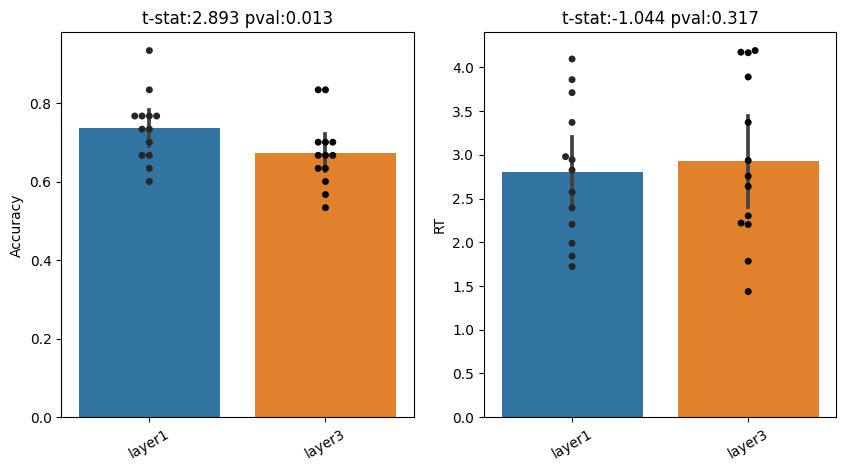

In [77]:
import seaborn as sns



d1 = final_participants_df['testing_layer_1_accuracy']
d2 = final_participants_df['testing_layer_3_accuracy']
t_stat, p_value = stats.ttest_rel(d1, d2)

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.barplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0])
sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')
axes[0].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')

sns.barplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1])
sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1],color='k')


d1 = final_participants_df['testing_layer_1_rt']
d2 = final_participants_df['testing_layer_3_rt']
t_stat, p_value = stats.ttest_rel(d1, d2)

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('RT')
axes[1].set_title(f't-stat:{t_stat:.3f} pval:{p_value:.3f}')


Text(0, 0.5, 'RT')

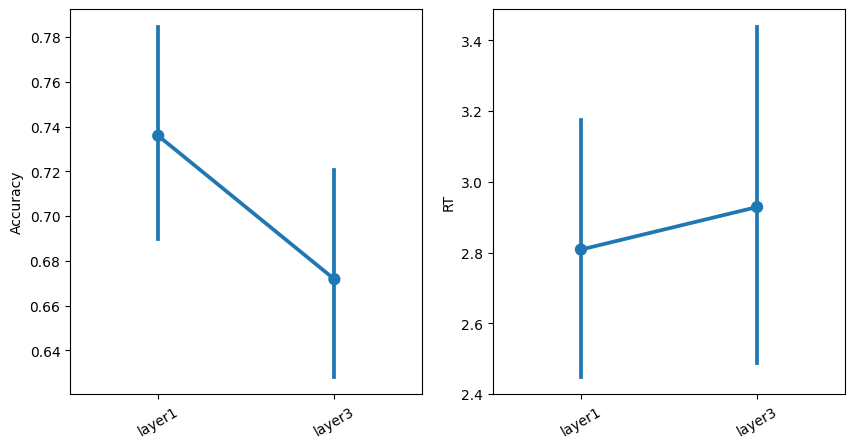

In [78]:
import seaborn as sns

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.pointplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_3_accuracy']],ax=axes[0])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']],ax=axes[0],color='k')

axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_ylabel('Accuracy')

sns.pointplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_3_rt']],ax=axes[1])
#sns.swarmplot(data=final_participants_df[['testing_layer_1_rt','testing_layer_2_rt','testing_layer_3_rt']],ax=axes[1],color='k')

axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].set_ylabel('RT')


In [79]:
final_participants_df['worker_ID'] = final_participants_df.index
rt_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_rt','testing_layer_3_rt'],var_name='layer')

accuracy_df = pd.melt(final_participants_df,id_vars=['worker_ID'],value_vars=['testing_layer_1_accuracy','testing_layer_3_accuracy'],var_name='layer')

C:\Users\User\AppData\Local\Temp\ipykernel_19928\624518973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_participants_df['worker_ID'] = final_participants_df.index


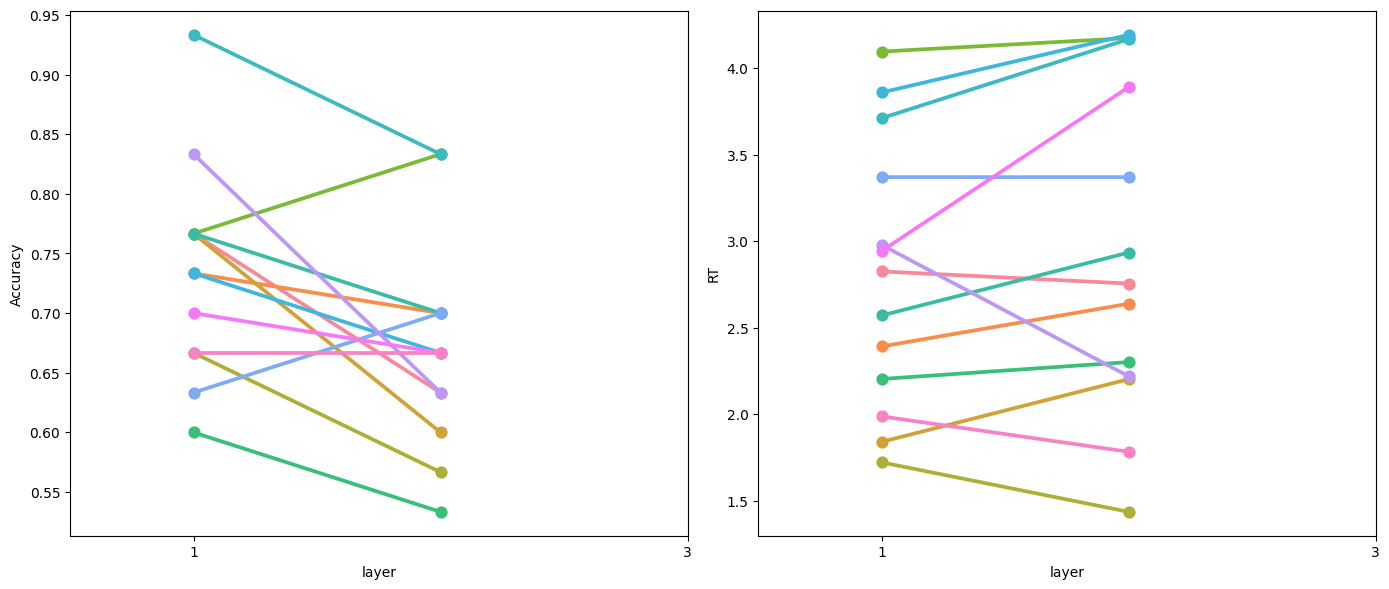

In [80]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6),sharex=True,sharey=False)
#accuracy: 
G = sns.pointplot(data=accuracy_df,x='layer', y='value', hue='worker_ID', ax=axes[0])
plt.xticks([0,2],['1','3'])
axes[0].set_ylabel('Accuracy')
axes[0].get_legend().remove() 

#rt: 
sns.pointplot(data=rt_df,x='layer', y='value', hue='worker_ID', ax=axes[1])
plt.xticks([0,2],['1','3'])
plt.ylabel('RT')
axes[1].get_legend().remove() 
plt.tight_layout()

## RATING ANALYSIS

<Axes: ylabel='Frequency'>

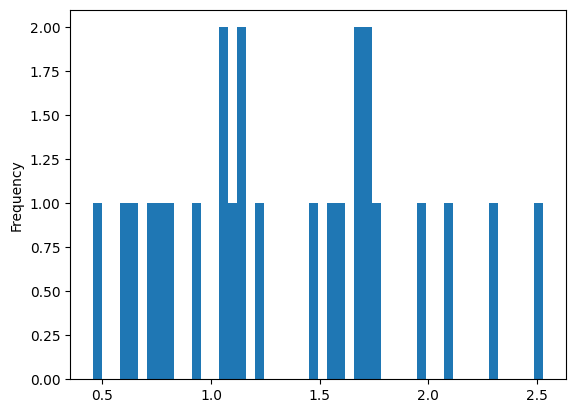

In [81]:
all_subjects_test_df.groupby('subject')['bar_2.response'].std().plot(kind='hist',bins = 50)

<Axes: xlabel='layer', ylabel='bar_2.response'>

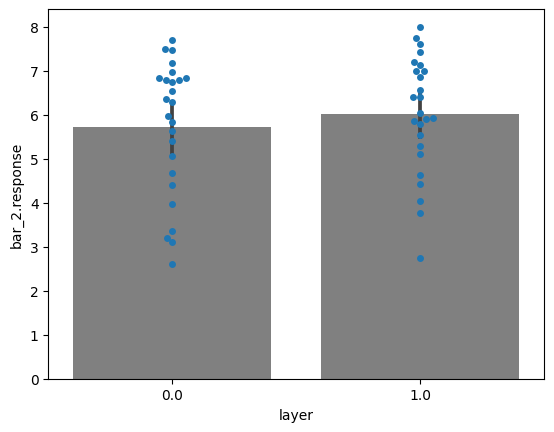

In [82]:
import seaborn as sns

# create the DataFrame
data = all_subjects_test_df.groupby(['subject','layer'])['bar_2.response'].mean().reset_index()

# plot the swarmplot and barplot on the same figure
fig, ax = plt.subplots()
sns.swarmplot(x='layer', y='bar_2.response', data=data, ax=ax)
sns.barplot(x='layer', y='bar_2.response', data=data, color='gray', ax=ax)

In [83]:
layer0_df_rating_accuracy = all_subjects_test_df[all_subjects_test_df['layer']==0].groupby(['subject']).aggregate({'bar_2.response':'mean','test_test_response.corr':'mean'}).corr()
display(layer0_df_rating_accuracy)

layer6_df_rating_accuracy = all_subjects_test_df[all_subjects_test_df['layer']==1].groupby(['subject']).aggregate({'bar_2.response':'mean','test_test_response.corr':'mean'}).corr()
display(layer6_df_rating_accuracy)

,bar_2.response,test_test_response.corr
bar_2.response,1.000000,-0.173852
test_test_response.corr,-0.173852,1.000000


,bar_2.response,test_test_response.corr
bar_2.response,1.000000,-0.232425
test_test_response.corr,-0.232425,1.000000


In [84]:
from scipy import stats

# create separate arrays for the data for each layer
layer0_data = data.loc[data['layer']==0, 'bar_2.response']
layer1_data = data.loc[data['layer']==1, 'bar_2.response']

# perform a paired t-test
t_stat, p_value = stats.ttest_rel(layer0_data, layer1_data)

# print the results
print('Paired t-test results:')
print(f't-statistic: {t_stat:.3f}')
print(f'p-value: {p_value:.3f}')

Paired t-test results:
t-statistic: -2.306
p-value: 0.030


In [85]:
#this is the updated shelf: copy from here and place in the shelf location in pavlovia.org
new_shelf_dict=shelf_dict.copy()


clean_shelf_after_test=True #change to true if you run this code after completing both encoding and test sessions and want to also resert participants that didnt come back at all... 
if clean_shelf_after_test: 


    allowed_interval_in_hours=24
    allowed_jitter=3
    allowed_interval_in_ms=[allowed_interval_in_hours-allowed_jitter,allowed_interval_in_hours+allowed_jitter]*3600*1000


    new_shelf_dict=shelf_dict.copy()
    changed_keys_list=[]
    for key in new_shelf_dict.keys():
        cur_entries=new_shelf_dict[key]
        if len(cur_entries)==2: 
            cur_entries[0]=999
            changed_keys_list.append(key)

        if None in cur_entries:
            cur_entries[0]=999
            changed_keys_list.append(key)

        if len(cur_entries)>2:
            encoding_time=cur_entries[1]
            last_entree=cur_entries[-1]
            if None in cur_entries:
                cur_entries[0]=999
                changed_keys_list.append(key)
            elif (last_entree - encoding_time) < allowed_interval_in_ms[0]:
                cur_entries[0]=999
                changed_keys_list.append(key)


        new_shelf_dict[key]=cur_entries

    print('changed entrees for:',changed_keys_list)

    ##### print the updated shelf dictionary so you can copy it from the cell output and paste in the shelf:  (change the shelf only if you run this code after both encoding and TEST has ended) ####
    new_shelf_dict


changed entrees for: ['A26RO8GGTQAXGG', 'A2Z5IN28H6PBVR', 'A29167TQYCEXWM', 'A15EHYMEITNBWE', 'A18GEAFI5MMW02', 'A5TA5GW8JS8HD', 'A16BUREYCTMSOC', 'A7RFFVAR7SANB', 'A12PR5DPEZ5I3U', 'AULLJBJ252TKH', 'A2P49UVZY1KWAQ', 'A3HFB277V5OXY0', 'A1GQWLAZQZP5VR', 'AOYDGVOZUIHII', 'AFFG9L9ZD9LUU', 'A7ZTU5G23PGDQ', 'A2G8KE4Z8TJOP5', 'A3APWAX21I89WB', 'A1F0VEHWK3IAF4', 'A283ZLAO3AKQQD', 'A1IBY7KXFHJ2U2', 'ALN6JHRB0JCUO', 'A2893LTGS44DN0SM', 'A33IGG1PDP3772', 'AGI6QH3NG97RS', 'A2893LTGSDN0SM', 'A3NKC7I9FOH6E3', 'A3UDJL809LPCVW', 'A2F2JW30D1348R', 'A33LB9PPW3LRLZ', 'A15VNIBHCLLROB', 'A177M9OIBDUWFW', 'A2LAXPTVI3IP1B', 'A2G90U50R5PBXX', 'A1T8VILAKHKGR1', 'A1B8OVQXUY3WQ6', 'A1Y3JL53XAO7QV', 'A29GU10CS7PZ1I', 'A2C27RE7LICITR', 'A3SPNL1K24NIY1', 'A2M5S1RXUCVE7L', 'A13THDIE8LTQ11', 'A2646YGRS0G84', 'ALP4Y6CZU2OSL', 'ASS3WREGCSW', 'A1OWRV6C175GTM', 'AWOL38XDW8O9', 'AB6L60HXUNORT', 'A2J4GCDXLDHYXX', 'A2J4GCDXLDHYXX', 'A32X0F5US6NJY1', 'A1DDWUJ5R357SW', 'A1DDWUJ5R357SW', 'A2Y878HLK0XENF', 'A38XR4TYZAWC6I', 'A

In [86]:
final_participants_df.head()

,demo_arrow_rt,demo_arrow_correct,demo_demo_accuracy,demo_RT_overall_mean,demo_rating_varience,demo_RT_incorrect_mean,demo_RT_correct_mean,encoding_arrow_mean_rt,encoding_arrow_accuracy,testing_Test_overall_accuracy,...,testing_layer_1_rating,testing_layer_3_rating,testing_RT_incorrect_mean,testing_RT_correct_mean,testing_layer_1_rt,testing_layer_1_accuracy,testing_layer_3_rt,testing_layer_3_accuracy,testing_longest_response_strike,worker_ID
A151XA53WYXVD7,1.1640,1.0,0.666667,4.281333,0.516398,3.440500,4.701750,1.08440,1.0,0.700000,...,5.066667,6.400000,2.811944,3.320476,2.826267,0.766667,2.756071,0.633333,7.0,A151XA53WYXVD7
A1969Q0R4Y0E3J,0.6609,1.0,0.666667,3.215017,1.940790,3.956100,2.844475,0.50754,1.0,0.716667,...,3.366667,4.633333,3.260712,2.432247,2.392666,0.733333,2.639617,0.700000,7.0,A1969Q0R4Y0E3J
A1VJ4ZOXP9PUCP,0.6974,1.0,1.000000,1.991400,0.752773,NaN,1.991400,0.87648,1.0,0.683333,...,4.400000,5.933333,2.201379,1.939927,1.841797,0.766667,2.203643,0.600000,4.0,A1VJ4ZOXP9PUCP
A20ZFQ93DF0WA,0.9519,1.0,0.833333,2.439050,0.752773,2.239900,2.478880,1.14720,1.0,0.616667,...,6.833333,6.400000,1.538117,1.606276,1.723217,0.666667,1.437080,0.566667,6.0,A20ZFQ93DF0WA
A237PUN7791D62,0.5593,1.0,0.500000,5.564150,2.280351,5.355933,5.772367,0.59406,1.0,0.800000,...,5.400000,5.800000,4.682217,3.998525,4.096250,0.766667,4.174277,0.833333,5.0,A237PUN7791D62


In [87]:
#find all participants that exists in the shelf, and make sure they have a participantion code (so they wont be able to come back to this experiemnt)
all_shelf_workers_that_are_assigned_participantion=[]
for curr_key in shelf_dict.keys():
    if curr_key in workers_df['Worker ID'].values:
        workers_df.loc[workers_df['Worker ID']==curr_key,qualification_name_for_entire_experiment]=1
        all_shelf_workers_that_are_assigned_participantion.append(curr_key)

print(f'{len(all_shelf_workers_that_are_assigned_participantion)} were given a {qualification_name_for_entire_experiment}, names: {all_shelf_workers_that_are_assigned_participantion}')

#create a new shelf, that only contains the ids and numbers of valid participants (this is so we wont re-use thier custom trials order (csvs))
new_shelf_dict=dict()
for sub_id in final_participants_df.index: 
    new_shelf_dict[sub_id]=shelf_dict[sub_id]
new_shelf_dict  

# add the final state of the previous batch 
previous_batch = 'batch ' + str(int(batch_name[-1]) - 1)
root_dirs = list(PATH_TO_BATCH.parent.iterdir())
target_dir = PATH_TO_BATCH.parent/ previous_batch
if target_dir in root_dirs:
    path_final_state_shelf = target_dir / 'shelf final state.txt'
    with open(path_final_state_shelf) as f:
        data = f.read()
        shelf_dict = json.loads(data)
    
    new_shelf_dict = new_shelf_dict | shelf_dict


print('\n\ncopy the following dictionary content to the pavlovia dictionary, and to the "shelf final state.txt"\n')
json.dumps(new_shelf_dict)

110 were given a UPDATE-completed multicategory memory test, names: ['A19PB6VUP0RAC3', 'A1ABRVTR49OA73', 'A1AMGHYG5PT0L2', 'A1BQLX0A4W8A8', 'A1DIYFGQT1QDV2', 'A1PRUVH5Q0T9FS', 'A1Q3GKUJF8EWHG', 'A1YALKEEJHHWSO', 'A2AN972XU7OY8W', 'A2F48NO7AD9VKK', 'A2FREFX5AGACUZ', 'A2J9NFY45NKR2N', 'A2NC28XJKAFJV', 'A39KMTFHRJJASK', 'A3EWBTHYFI4I6Q', 'A27KTNOX292J1I', 'A2APG8MSLJ6G2K', 'A2NAKIXS3DVGAA', 'A2OQ5LQ3YB4HX1', 'A2U44IH2MUK32A', 'A2WHAIUPGYCFN6', 'A3G55RJTW3BSGM', 'A3HQXCWOIQKT4F', 'A3PIJBZIF34XR2', 'A3SFP9VSFJY2YW', 'A3UA50A6GKNAMR', 'A5P12YJP805RG', 'A8C3WNWRBWUXO', 'A9HQ3E0F2AGVO', 'AEK2SAEL9GG39', 'A26RO8GGTQAXGG', 'A3LBMZYPY37NRW', 'A18GEAFI5MMW02', 'A1VJ4ZOXP9PUCP', 'A30C7BD86P06O6', 'A2541C8MY0BYV3', 'A16BUREYCTMSOC', 'A7RFFVAR7SANB', 'A237PUN7791D62', 'AULLJBJ252TKH', 'AC01SVLHOB6HN', 'A31LNMK1LGOIIA', 'A2P49UVZY1KWAQ', 'AOWTBF2L04ENM', 'A3HFB277V5OXY0', 'A1GQWLAZQZP5VR', 'AOYDGVOZUIHII', 'AFFG9L9ZD9LUU', 'AJT7C07A187KA', 'A2CZ5PS567SA10', 'A1F0VEHWK3IAF4', 'A3AU8PZ6HHBCVT', 'A283ZLA

'{"A151XA53WYXVD7": [86, 1683140235606, 1683215006376, 1683219901068], "A1969Q0R4Y0E3J": [51, 1683129155098, 1683212084517], "A1VJ4ZOXP9PUCP": [14, 1683125730181, 1683196275611, 1683200940480, 1683206035683], "A20ZFQ93DF0WA": [89, 1683140297456, 1683231171870], "A237PUN7791D62": [20, 1683126058101, 1683221105949], "A2541C8MY0BYV3": [16, 1683125900748, 1683216850771], "A2TQ9IHDHCSQC8": [97, 1683141086977, 1683234349359], "A2UWEAIX8UZXAQ": [52, 1683129279420, 1683208577356], "A32X8WXMIV4KE8": [75, 1683135723028, 1683213686494], "A3ATB5GC4BQIH0": [41, 1683129058171, 1683208304032], "A3AU8PZ6HHBCVT": [43, 1683127052494, 1683207536281], "AC01SVLHOB6HN": [25, 1683126228653, 1683216864203], "AW07POT8ABE05": [71, 1683134378210, 1683216432019], "A19PB6VUP0RAC3": [9, 1682949997166, 1683029612907, 1683030155680], "A1ABRVTR49OA73": [21, 1682950049077, 1683032370299, 1683041181284], "A1AMGHYG5PT0L2": [39, 1682950918763, 1683033162919], "A1BQLX0A4W8A8": [83, 1682964250527, 1683030823745, 16830309305

In [88]:
batch_workers_df_extended.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_extended_with_disqualification.csv'))
workers_df.to_csv(PATH_TO_BATCH / path.Path(batch_name+'_workers_results_for_upload_after_encoding_and_test.csv'))